# Emulators: Measuring performance

This example illustrates how different neural networks perform in emulating the log-likelihood surface of a time series and in Bayesian inference, using a two-step MCMC procedure with emulator neural networks [Emulated Metropolis MCMC](../sampling/first-example.ipynb).

It follows on from [Emulators: First example](../mcmc/first-example-emulator.ipynb)

Like in the first example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0] # rescaled true parameters

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("Gaussian noise:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)
values = org_values + np.random.normal(0, noise, org_values.shape)

Gaussian noise: 24.898095903089327


Using matplotlib and seaborn (optional - for styling), I look at the noisy time series I just simulated:

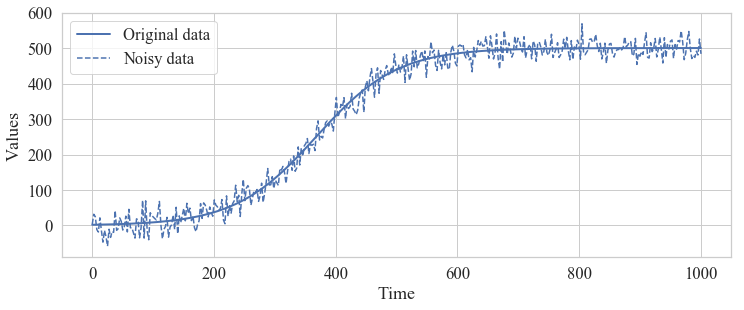

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
palette = itertools.cycle(sns.color_palette())
c=next(palette)

fig = plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, org_values, lw=2, c=c, label='Original data')
plt.plot(times, values, '--', c=c, label='Noisy data')
plt.legend()
plt.show()
fig.savefig("figures/logistic.png", bbox_inches='tight', dpi=200)

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create (rescaled) bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions, using the rescaled true parameters:

In [12]:
x0 = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

## Using Pints' diagnostic plots to inspect the results

I then take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, I use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution and check out the resulting sample histograms.

Based on this plot, it looks like the three chains become very similar after about 100 iterations.
To be safe, I throw away the first 2000 samples and continue the analysis with the first chain.

Then, I inspect the inferred parameter distribution by plotting histograms:

Here, each parameter is analyzed in isolation, but we can also look at correlations between parameters using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, I'll apply some _thinning_ to the chain:

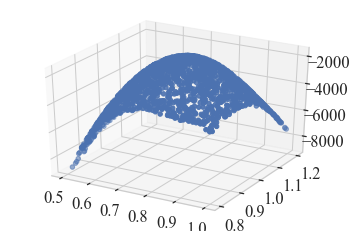

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()
fig.savefig("figures/training-data-best-nn-6-64.png", bbox_inches='tight', dpi=200)

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 82,753
Trainable params: 82,753
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Create higher bounds for our parameters and get MAPE
bounds_high = pints.RectangularBoundaries([0.85, 1.1], [1.0, 1.2])
log_prior_high = pints.UniformLogPrior(bounds_high)
input_parameters_high = log_prior_high.sample(5000)

likelihoods_high = np.apply_along_axis(log_likelihood, 1, input_parameters_high)
emu_high = (np.apply_along_axis(emu, 1, input_parameters_high)).reshape((5000,))

mape_high = np.mean(np.abs(np.subtract(likelihoods_high, emu_high) / likelihoods_high))
mape_high

0.035983852123290264

In [16]:
# Create lower bounds for our parameters and get MAPE
bounds_low = pints.RectangularBoundaries([0.5, 0.8], [0.65, 0.9])
log_prior_low = pints.UniformLogPrior(bounds_low)
input_parameters_low = log_prior_low.sample(5000)

likelihoods_low = np.apply_along_axis(log_likelihood, 1, input_parameters_low)
emu_low = (np.apply_along_axis(emu, 1, input_parameters_low)).reshape((5000,))

mape_low = np.mean(np.abs(np.subtract(likelihoods_low, emu_low) / likelihoods_low))
mape_low

0.025469854612393723

In [17]:
# Create normal bounds for our parameters and get MAPE
bounds_normal = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior_normal = pints.UniformLogPrior(bounds_normal)
input_parameters_normal = log_prior_normal.sample(5000)

likelihoods_normal = np.apply_along_axis(log_likelihood, 1, input_parameters_normal)
emu_normal = (np.apply_along_axis(emu, 1, input_parameters_normal)).reshape((5000,))

mape_normal = np.mean(np.abs(np.subtract(likelihoods_normal, emu_normal) / likelihoods_normal))
mape_normal

0.018680774476853863

In [18]:
emu([0.75, 1])

array([[-1815.1243]], dtype=float32)

In [19]:
log_likelihood([0.75, 1])

-1853.009880224935

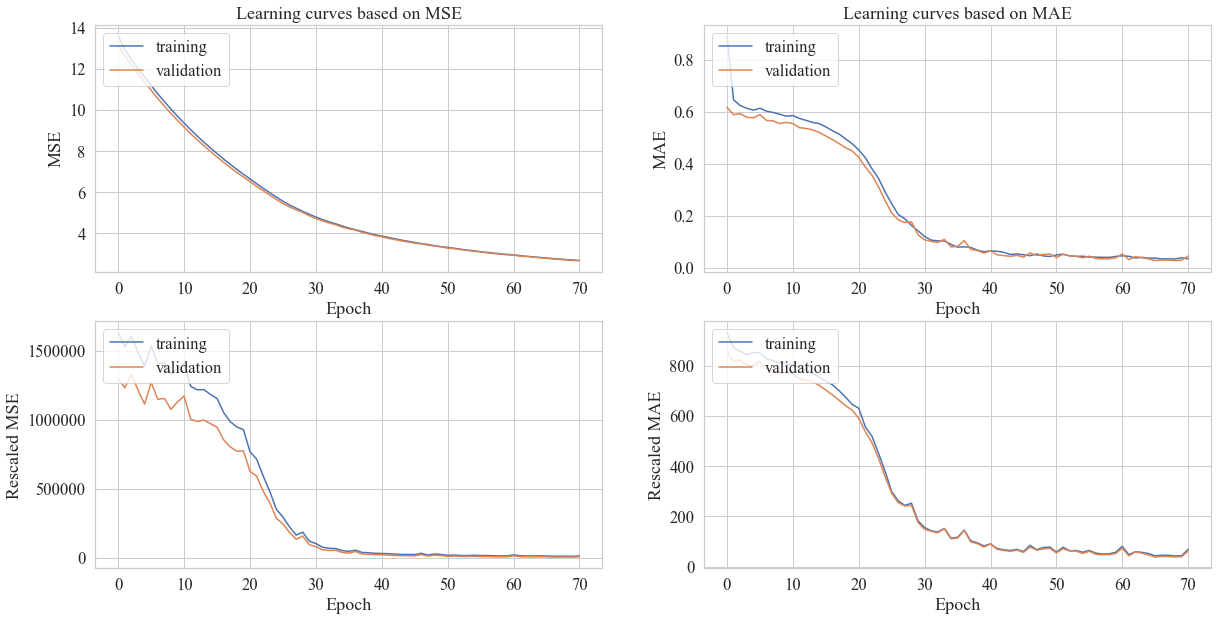

In [20]:
# summarize history for loss
#print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()
fig.savefig("figures/training-nn-6-64.png", bbox_inches='tight', dpi=200)

In [21]:
len(hist.history['loss'])

71

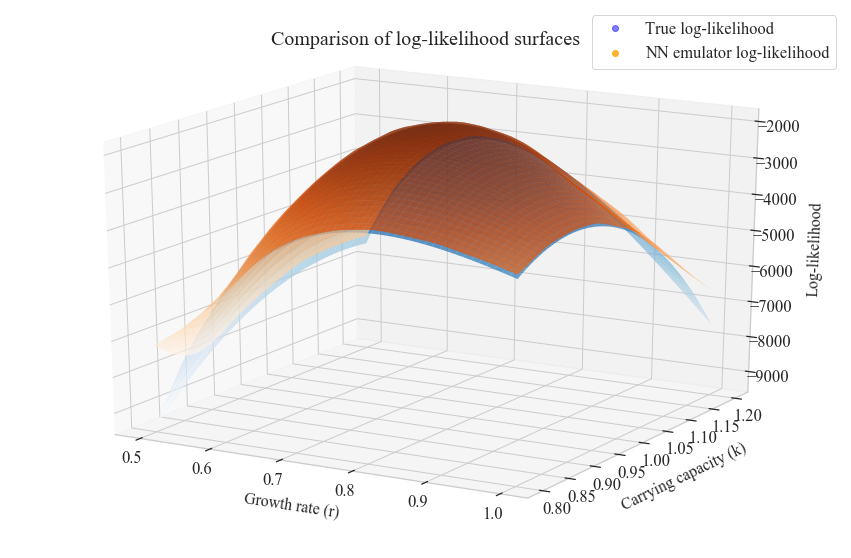

0.019663271208646863

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D 

sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})

test_splits = 50 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)
emu_prediction = pints.predict_grid(emu, test_data)

figsize=(20,10)
angle=(20, 300)
alpha=0.7
fontsize=16
labelpad=15

title = "Comparison of log-likelihood surfaces"
x_label = "Growth rate (r)"
y_label = "Carrying capacity (k)"
z_label = "Log-likelihood"


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(r_grid, k_grid, model_prediction, cmap='Blues', edgecolor='none', alpha=alpha)
ax.plot_surface(r_grid, k_grid, emu_prediction, cmap='Oranges', edgecolor='none', alpha=alpha)
#ax.view_init(60, 35)
ax.view_init(*angle)
#ax.set_title('surface')

plt.title(title, fontsize=fontsize*1.25)
ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o', alpha=0.5)
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='orange', marker = 'o', alpha=0.8)
ax.legend([fake2Dline1, fake2Dline2], ["True log-likelihood", "NN emulator log-likelihood"])
plt.show()
fig.savefig("figures/likelihood-surfaces-nn-6-64.png", bbox_inches='tight', dpi=100)

mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

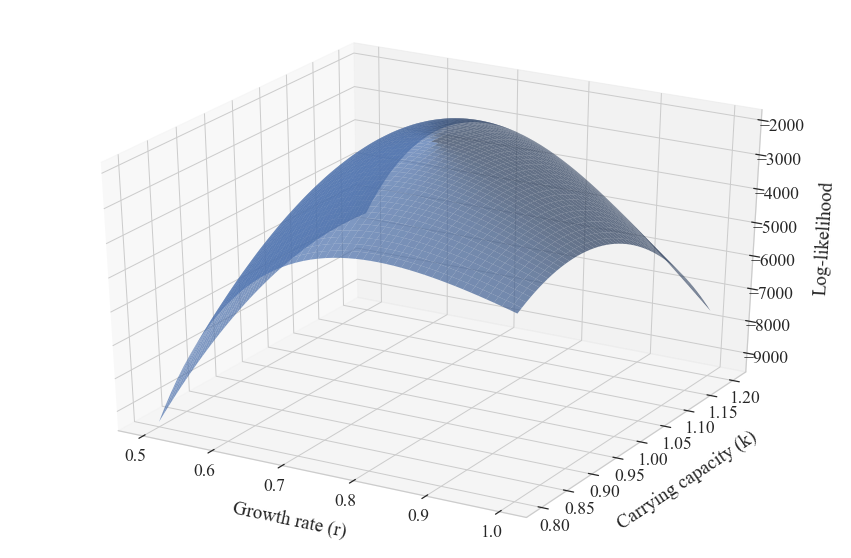

In [23]:
sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.6, color_codes=True, rc={"grid.linewidth": 1})

test_splits = 50 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)
emu_prediction = pints.predict_grid(emu, test_data)

figsize=(20,10)
angle=(20, 300)
alpha=0.7
labelpad=20

x_label = "Growth rate (r)"
y_label = "Carrying capacity (k)"
z_label = "Log-likelihood"

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(r_grid, k_grid, model_prediction, edgecolor='none', alpha=alpha)
#ax.view_init(*angle)
ax.set_xlabel(x_label, labelpad=labelpad)
ax.set_ylabel(y_label, labelpad=labelpad)
ax.set_zlabel(z_label, labelpad=labelpad)

plt.show()
fig.savefig("figures/logistic-likelihood-surface.png", bbox_inches='tight', dpi=100)

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [25]:
start_parameters

[0.75, 1.0]

In [26]:
sigma = np.array(start_parameters)*5e-05
sigma

array([3.75e-05, 5.00e-05])

## Running MCMC routines

### Adaptive Covariance MCMC

In [27]:
import time

n_chains = 3
n_iter = 30000 # Add stopping criterion
warm_up = int(0.2 * n_iter)
sigma0 = np.abs(start_parameters) * 5e-05 # Choose a covariance matrix for the proposal step
x0 = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]
scaling_factors = [1/50, 500]
param_names=["r", "k"]

Running...
[[ 1.09388299e-05 -4.00277097e-06]
 [-4.00277097e-06  1.57864886e-05]]
[[ 1.03274937e-05 -5.30053324e-06]
 [-5.30053324e-06  1.25528393e-05]]
[[ 9.45532670e-06 -3.24556344e-06]
 [-3.24556344e-06  1.13509792e-05]]
Done!
R-hat:
[1.000176971114792, 1.0001414947764151]


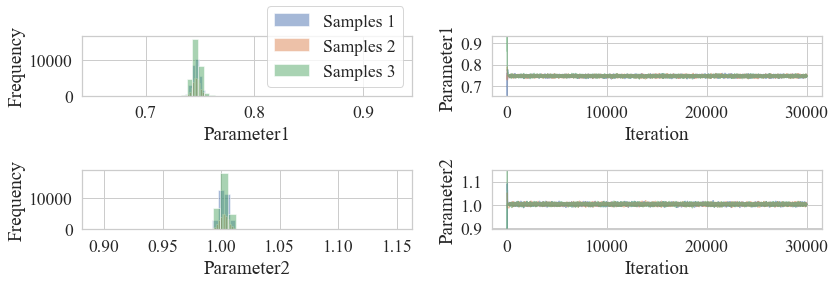

In [28]:
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, n_chains, x0)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
chains = mcmc.run()
end = time.time()
print('Done!')

ac_diff = end - start
ac_rates = mcmc.acceptance_rates()

# Discard warm up
chains_thinned = chains[:, warm_up:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thinned))

# Show traces and histograms
pints.plot.trace(chains)

# Look at distribution in chain 0
#pints.plot.pairwise(chains_thinned[0])

# Show graphs
plt.show()

In [29]:
print("Acceptance rates:", ac_rates)
print("Running time    :", ac_diff)

Acceptance rates: [0.2317, 0.2312, 0.2323]
Running time    : 20.61170220375061


In [30]:
ac_results = pints.MCMCSummary(chains=chains[:, warm_up:, :], time=ac_diff,
                            parameter_names=param_names)
ac_results.save('figures/nn-6-64-50000.xlsx', 'ac')

mean      std.      2.5%       25%       50%       75%     97.5%  \
param                                                                         
r      0.746334  0.003365  0.739744  0.744088  0.746319  0.748578  0.752988   
k      1.002115  0.003772  0.994884  0.999533  1.002074  1.004678  1.009488   

           rhat          ess  ess per sec.       time  
param                                                  
r      1.000177  6561.318197    318.329759  20.611702  
k      1.000141  7195.157020    349.081165  20.611702

### Standard Metropolis Hastings MCMC

Running...
Done!
R-hat:
[1.0004309195115118, 1.000097659544437]


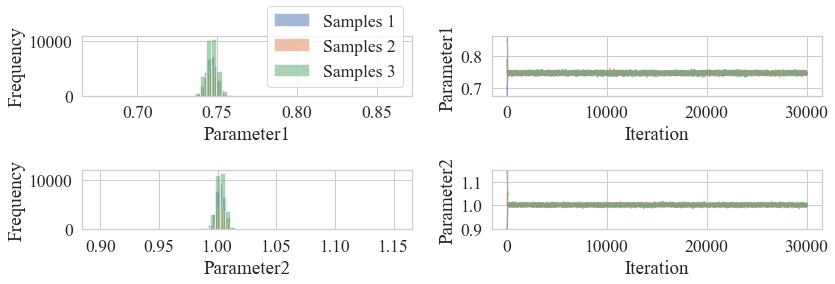

In [31]:
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, n_chains, x0, sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
metropolis_chains = mcmc.run()
end = time.time()
print('Done!')

metropolis_diff = end - start
metropolis_rates = mcmc.acceptance_rates()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains[:, warm_up:, :]))

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Look at distribution in chain 0
#pints.plot.pairwise(metropolis_chains[:, warm_up:, :][0])

# Show graphs
plt.show()

In [32]:
print("Acceptance rates:", metropolis_rates)
print("Running time    :", metropolis_diff)

Acceptance rates: [0.30386666666666995, 0.3034666666666641, 0.3035666666666657]
Running time    : 18.45177388191223


In [33]:
metropolis_results = pints.MCMCSummary(chains=metropolis_chains[:, warm_up:, :], 
                                       time=metropolis_diff, parameter_names=param_names)
# Revert scaling
metropolis_chains_rescaled = np.copy(metropolis_chains)
metropolis_chain_rescaled = metropolis_chains_rescaled[0]
metropolis_chain_rescaled = metropolis_chain_rescaled[warm_up:] # Discard warm up
metropolis_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                              for chain in metropolis_chains])
metropolis_chain = metropolis_chains[0]
metropolis_chain = metropolis_chain[warm_up:]

metropolis_results.save('figures/nn-6-64-50000.xlsx', 'metropolis')

mean      std.      2.5%       25%       50%       75%     97.5%  \
param                                                                         
r      0.746274  0.003376  0.739746  0.744000  0.746225  0.748527  0.752900   
k      1.002187  0.003797  0.994683  0.999646  1.002154  1.004759  1.009622   

           rhat          ess  ess per sec.       time  
param                                                  
r      1.000431  6523.432204    353.539570  18.451774  
k      1.000098  6502.189342    352.388306  18.451774

### Metropolis Hastings MCMC using NN as posterior

Running...
Done!
R-hat:
[1.000211585268595, 1.0003134072320405]


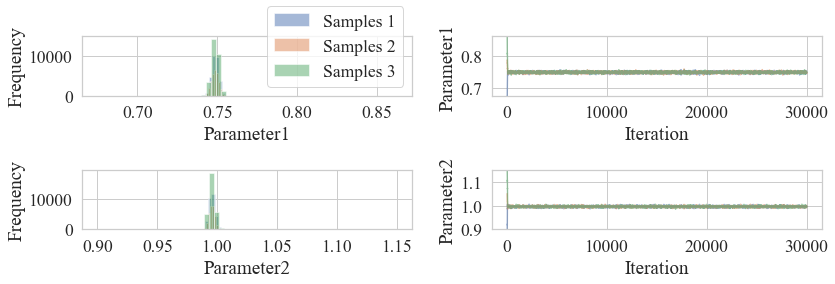

In [34]:
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, n_chains, x0, sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
chains_emu = mcmc.run()
end = time.time()
print('Done!')

nn_diff = end - start
nn_rates = mcmc.acceptance_rates()

# Discard warm up
chains_emu_thinned = chains_emu[:, warm_up:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thinned))

# Show traces and histograms
pints.plot.trace(chains_emu)

# Look at distribution in chain 0
#pints.plot.pairwise(chains_emu_thinned[0])

# Show graphs
plt.show()

In [35]:
print("Acceptance rates:", nn_rates)
print("Running time    :", nn_diff)

Acceptance rates: [0.17326666666666826, 0.1726000000000001, 0.1757000000000002]
Running time    : 59.39457154273987


In [36]:
nn_results = pints.MCMCSummary(chains=chains_emu[:, warm_up:, :], time=nn_diff,
                            parameter_names=param_names)

# Revert scaling
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[warm_up:]
chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])
chain_emu = chains_emu[0]
chain_emu = chain_emu[warm_up:]

nn_results.save('figures/nn-6-64-50000.xlsx', 'nn')

mean      std.      2.5%       25%       50%       75%     97.5%  \
param                                                                         
r      0.748614  0.002177  0.744380  0.747150  0.748639  0.750093  0.752821   
k      0.995427  0.002387  0.990915  0.993809  0.995395  0.996985  1.000255   

           rhat          ess  ess per sec.       time  
param                                                  
r      1.000212  5628.242291     94.760214  59.394572  
k      1.000313  5745.354978     96.731988  59.394572

### 2-Step MCMC using NN as emulator

Running...
Done!
R-hat:
[1.0004030899567171, 1.0017599474863494]


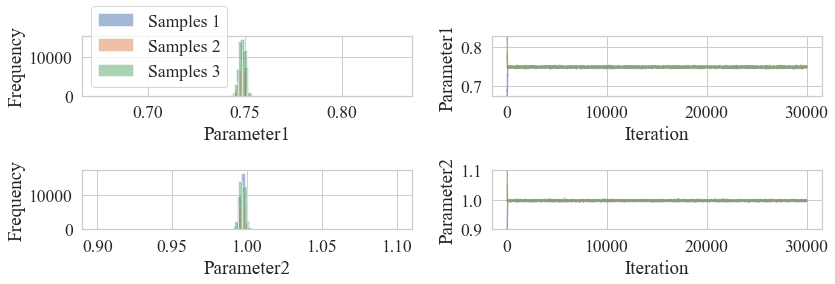

[(0.07956666666666681, 0.1519666666666662, 0.5235797323974556), (0.08263333333333342, 0.15683333333333263, 0.5268862911795962), (0.08213333333333332, 0.15530000000000005, 0.5288688559776776)]


In [37]:
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.10,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, n_chains, x0s, sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
emulated_chains = mcmc.run()
end = time.time()
print('Done!')

emulated_diff = end - start
emulated_rates = mcmc.acceptance_rates()

# Discard warm up
emulated_chains_thinned = emulated_chains[:, warm_up:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Look at distribution in chain 0
#pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

print(mcmc.acceptance_rates())

pdfs1 = mcmc.get_pdfs()

In [38]:
print(pdfs1)

[([-2749.4371590892015, -2734.5780955547125, -2839.381042728331, -2763.33906974866, -2657.8228073640075, -2639.6737963643736, -2618.6463083283147, -2819.836687844873, -2593.8458669155198, -2513.488643112287, -2483.5028825663803, -2416.269412171825, -2506.691585680635, -2513.8845602363162, -2475.0832703687774, -2502.3458193251695, -2438.028061889182, -2494.64776380437, -2401.834698883105, -2396.424628790706, -2347.3936090528114, -2372.513637822049, -2464.8435352392853, -2413.6343148562905, -2324.860850764332, -2422.186902925705, -2238.6864403661866, -2323.967365058143, -2169.570009851368, -2184.4965167573855, -2156.702514744531, -2150.939987685541, -2115.645745277379, -2057.221600832776, -2047.4321509331173, -2064.4127153898758, -1955.7058992413479, -1965.0817341865288, -1924.5910863796473, -1933.52884862048, -1952.2653744363577, -1945.0556698218782, -1919.449406297508, -1931.5845248544354, -1924.4603343379918, -1928.5612457779625, -1911.8544334534354, -1883.243854117933, -1903.44666005

Running...
Done!
R-hat:
[1.0021642371993518, 1.0005034214458635]


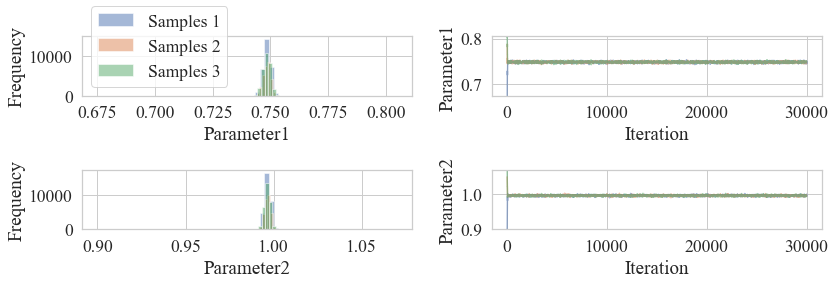

[(0.08516666666666647, 0.15953333333333405, 0.5338487254492269), (0.08090000000000042, 0.15149999999999908, 0.533993399339934), (0.08469999999999976, 0.15559999999999996, 0.544344473007712)]


In [39]:
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.07,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, n_chains, x0s, sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
emulated_chains = mcmc.run()
end = time.time()
print('Done!')

emulated_diff = end - start
emulated_rates = mcmc.acceptance_rates()

# Discard warm up
emulated_chains_thinned = emulated_chains[:, warm_up:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Look at distribution in chain 0
#pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

print(mcmc.acceptance_rates())

pdfs2 = mcmc.get_pdfs()

Running...
Done!
R-hat:
[1.0018010931458528, 1.0008138239467126]


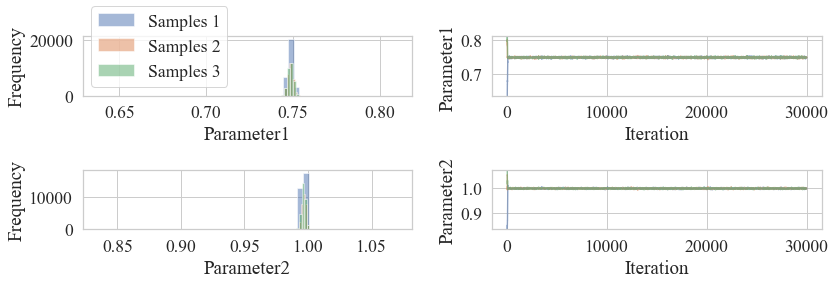

[(0.08146666666666655, 0.15603333333333327, 0.52211066011536), (0.0813333333333335, 0.15363333333333357, 0.5293990019527013), (0.07976666666666694, 0.15009999999999915, 0.5314234954474795)]


In [40]:
x0s = [
    np.array(start_parameters) * 0.85,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.07,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, n_chains, x0s, sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
emulated_chains = mcmc.run()
end = time.time()
print('Done!')

emulated_diff = end - start
emulated_rates = mcmc.acceptance_rates()

# Discard warm up
emulated_chains_thinned = emulated_chains[:, warm_up:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Look at distribution in chain 0
#pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

print(mcmc.acceptance_rates())

pdfs3 = mcmc.get_pdfs()

Running...
Done!
R-hat:
[1.0005597219929199, 1.0006580800808413]


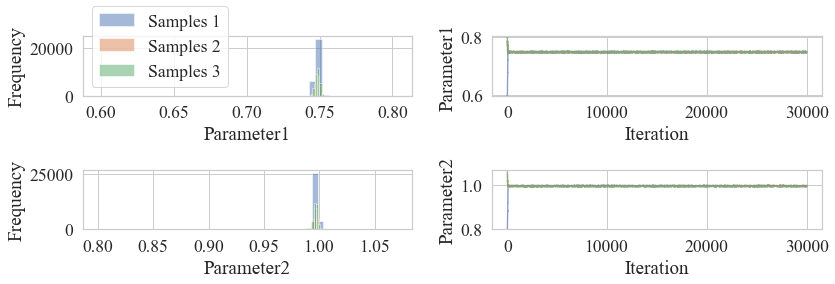

[(0.0895000000000003, 0.16106666666666772, 0.5556705298013245), (0.0843000000000003, 0.15766666666666865, 0.5346723044397463), (0.08323333333333341, 0.1527666666666653, 0.5448396246999782)]


In [41]:
x0s = [
    np.array(start_parameters) * 0.8,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.07,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, n_chains, x0s, sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
emulated_chains = mcmc.run()
end = time.time()
print('Done!')

emulated_diff = end - start
emulated_rates = mcmc.acceptance_rates()

# Discard warm up
emulated_chains_thinned = emulated_chains[:, warm_up:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Look at distribution in chain 0
#pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

print(mcmc.acceptance_rates())

pdfs4 = mcmc.get_pdfs()

Running...
Done!
R-hat:
[1.0006210567568297, 1.0010368410074857]


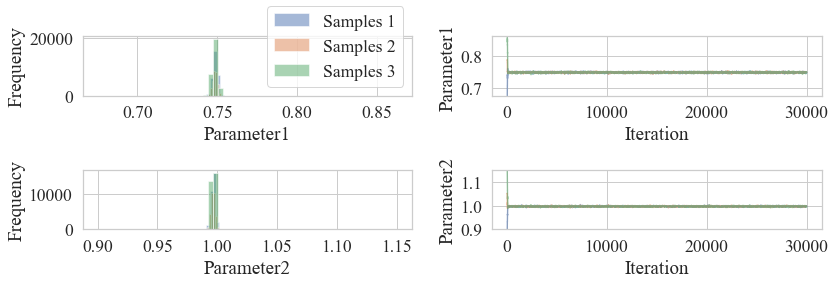

([-2609.68344538553, -2610.491850837747, -2517.4897875792476, -2783.4524591861536, -2474.474176829661, -2385.1349562446394, -2436.0220573126708, -2419.979691845837, -2312.376597035356, -2352.9851545932524, -2371.6513852655344, -2240.349659709094, -2331.4688223949406, -2305.3131985906066, -2254.078872880931, -2374.079563018402, -2178.828194758211, -2241.9453291730397, -2130.9605103636286, -2046.3763854372357, -2053.977310905664, -2081.9466854946295, -1987.6815868656918, -2022.8251895116916, -2036.7681209488348, -1999.3493861120885, -2008.0404904176485, -1979.4120094748778, -1987.3503259058286, -1961.648592665539, -1983.2946081990135, -1980.0509009724294, -1946.6534897101812, -1983.3171404749532, -1939.5108395594843, -1942.1002649774932, -1932.5175597122657, -1966.499160676805, -1996.1060495471447, -1922.065746736684, -1910.224032523608, -1905.5236113723274, -1898.0716555447286, -1897.097487245316, -1898.3922732088083, -1918.4528495073355, -1892.5335835585572, -1928.0766340246707, -1944.

In [42]:
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, n_chains, x0, sigma0, method=pints.EmulatedMetropolisMCMC, 
                            f=log_posterior)#, debug=["a","b","c"])

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
emulated_chains = mcmc.run()
end = time.time()
print('Done!')

emulated_diff = end - start
emulated_rates = mcmc.acceptance_rates()

# Discard warm up
emulated_chains_thinned = emulated_chains[:, warm_up:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Look at distribution in chain 0
#pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

pdfs = mcmc.get_pdfs()
print(pdfs[0])

In [43]:
print("Acceptance rates:\n", emulated_rates)
print("Running time    :", emulated_diff)

Acceptance rates:
 [(0.08299999999999949, 0.1550666666666662, 0.5352536543422184), (0.08263333333333384, 0.1548000000000005, 0.5338070628768303), (0.08480000000000017, 0.15686666666666726, 0.5405864853378666)]
Running time    : 66.2885193824768


In [44]:
emulated_results = pints.MCMCSummary(chains=emulated_chains[:, warm_up:, :], time=emulated_diff,
                            parameter_names=param_names)

# Revert scaling
emulated_chains_rescaled = np.copy(emulated_chains)
emulated_chain_rescaled = emulated_chains_rescaled[0]
emulated_chain_rescaled = emulated_chain_rescaled[warm_up:]
emulated_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                            for chain in emulated_chains])
emulated_chain = emulated_chains[0]
emulated_chain = emulated_chain[warm_up:]

emulated_results.save('figures/nn-6-64-50000.xlsx', '2-steps')

mean      std.      2.5%       25%       50%       75%     97.5%  \
param                                                                         
r      0.748456  0.001508  0.745388  0.747454  0.748531  0.749491  0.751198   
k      0.996516  0.001635  0.993284  0.995413  0.996550  0.997621  0.999606   

           rhat          ess  ess per sec.       time  
param                                                  
r      1.000621  2720.580112     41.041498  66.288519  
k      1.001037  2700.577551     40.739748  66.288519

## Examining NN performance

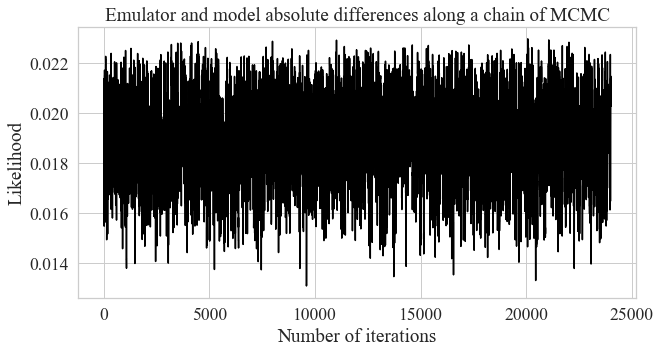

0.018903039373317238

In [45]:
emu_prediction = np.apply_along_axis(emu, 1, metropolis_chain_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, metropolis_chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, len(metropolis_chain_rescaled), len(metropolis_chain_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs.mean()

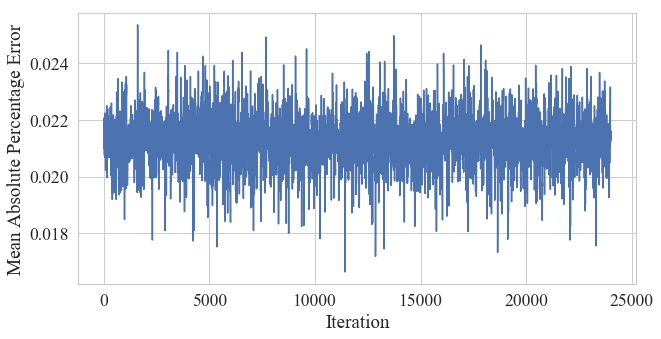

0.021233640301571044

In [46]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, metropolis_chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0,  len(chain_emu_rescaled), len(chain_emu_rescaled))
fig = plt.figure(figsize=(10, 5))
#plt.title("Comparison of emulator and model along an MCMC chain")
plt.xlabel("Iteration")
plt.ylabel("Mean Absolute Percentage Error")
plt.plot(iters, diffs)
plt.show()
fig.savefig("figures/mcmc-diffs-nn-6-64.png", bbox_inches='tight', dpi=200)

diffs[-1]

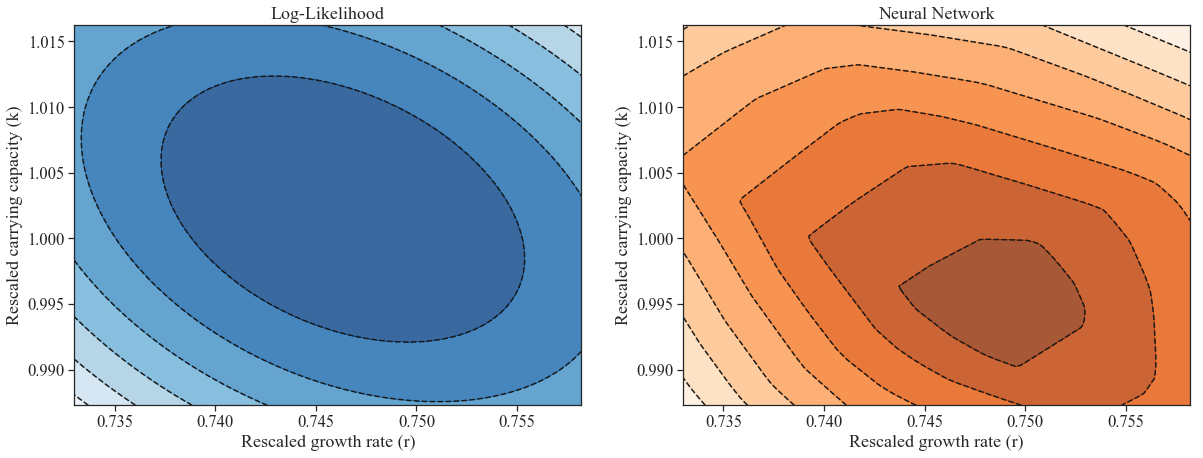

In [47]:
sns.set(context='notebook', style='ticks', palette="deep", font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})

# Create grid of parameters
x = [p[0] for p in metropolis_chain_rescaled]
y = [p[1] for p in metropolis_chain_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.set_xlabel('Rescaled growth rate (r)')
ax1.set_ylabel('Rescaled carrying capacity (k)')
ax2.set_xlabel('Rescaled growth rate (r)')
ax2.set_ylabel('Rescaled carrying capacity (k)')

ax1.contourf(xx, yy, ll, cmap='Blues', alpha=0.8, extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Oranges', alpha=0.8, extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()
fig.savefig("figures/close-contours-nn-6-64.png", bbox_inches='tight', dpi=200)

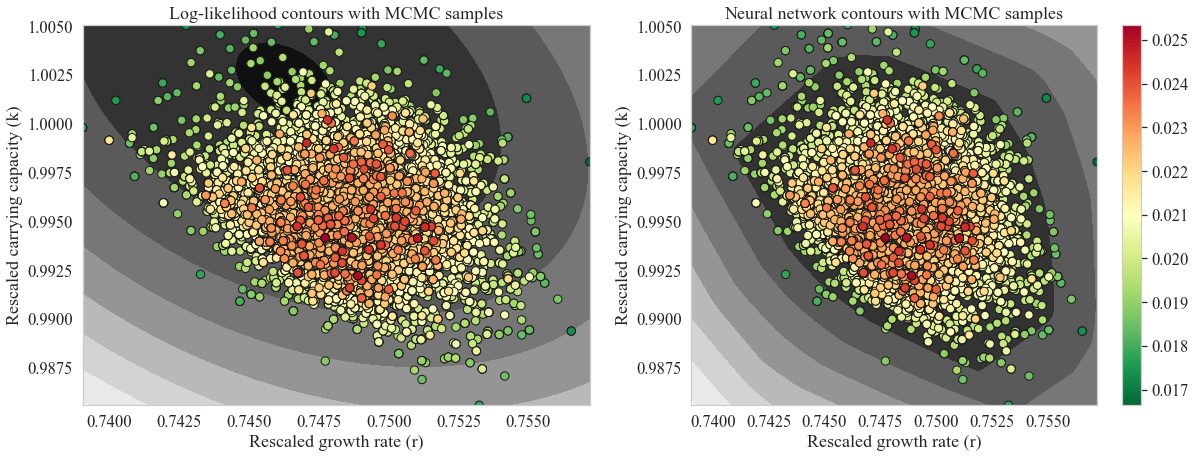

In [48]:
sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-likelihood contours with MCMC samples')
ax2.title.set_text('Neural network contours with MCMC samples') 
ax1.set_xlabel('Rescaled growth rate (r)')
ax1.set_ylabel('Rescaled carrying capacity (k)')
ax2.set_xlabel('Rescaled growth rate (r)')
ax2.set_ylabel('Rescaled carrying capacity (k)')

# Create grid of parameters
x = [p[0] for p in chain_emu_rescaled]
y = [p[1] for p in chain_emu_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
#ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
#ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

#fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()
fig.savefig("figures/errors-on-contours-nn-6-64.png", bbox_inches='tight', dpi=200)

## Comparing NN performance to 2-step MCMC performance

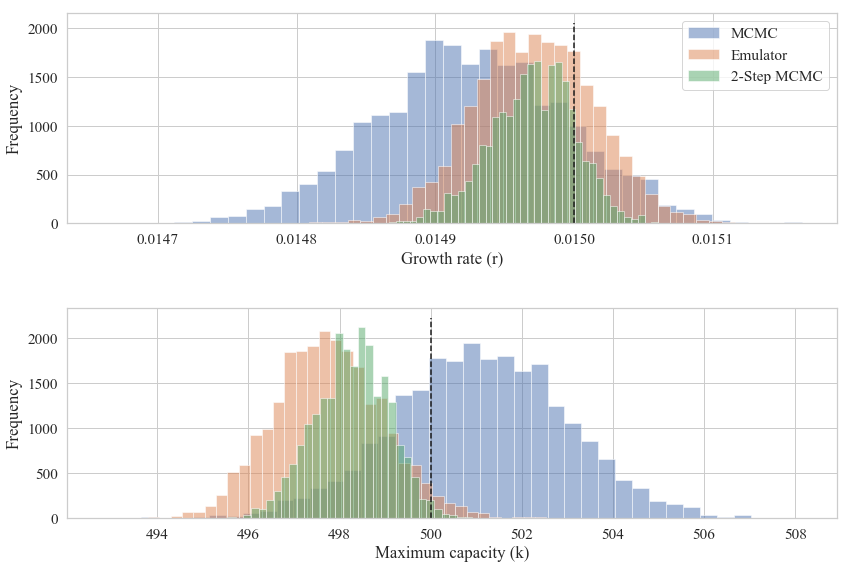

In [49]:
sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.4, color_codes=True, rc={"grid.linewidth": 1})

fig, axes = pints.plot.histogram([metropolis_chain, chain_emu, emulated_chain], 
                                ref_parameters=true_parameters, 
                                sample_names=["MCMC", "Emulator", "2-Step MCMC"],
                                parameter_names=["Growth rate (r)", "Maximum capacity (k)"])
#axes[0].set_title('Comparison of log-posterior sample distributions\n', fontsize=16)
fig.set_size_inches(14, 10)
plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()
fig.savefig("figures/log-posterior-samples-nn-6-64.png", bbox_inches='tight', dpi=200)

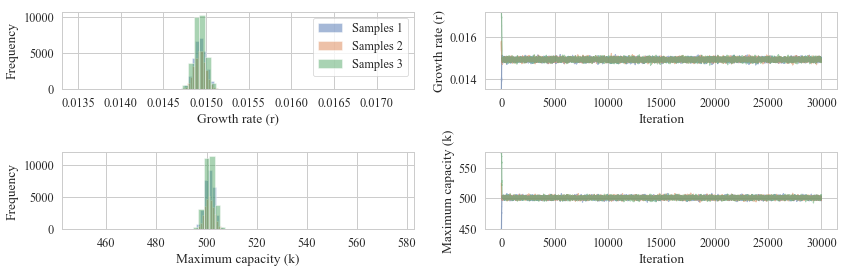

In [50]:
sns.set(context='paper', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.4, color_codes=True, rc={"grid.linewidth": 1})
fig, axes = pints.plot.trace(metropolis_chains, 
                             parameter_names=["Growth rate (r)", "Maximum capacity (k)"])
#fig.set_size_inches(14, 10)
#plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()
fig.savefig("figures/traces-chainmcmc-nn-6-64.png", bbox_inches='tight', dpi=200)

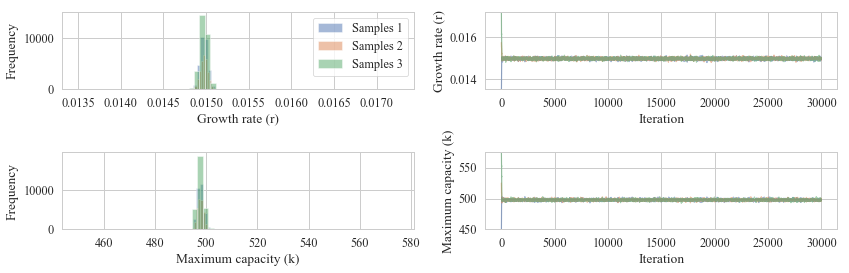

In [51]:
sns.set(context='paper', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.4, color_codes=True, rc={"grid.linewidth": 1})
fig, axes = pints.plot.trace(chains_emu, parameter_names=["Growth rate (r)", "Maximum capacity (k)"])
plt.show()
fig.savefig("figures/traces-chainemu-nn-6-64.png", bbox_inches='tight', dpi=200)

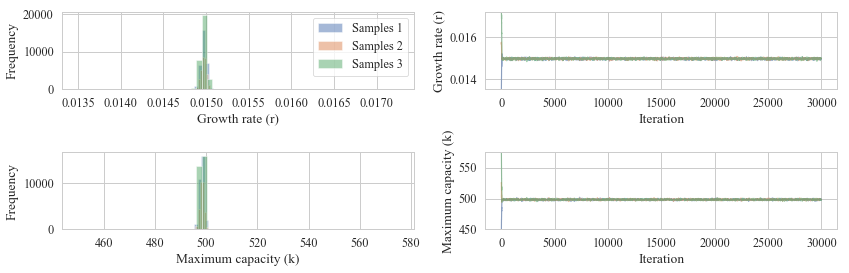

In [52]:
sns.set(context='paper', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.4, color_codes=True, rc={"grid.linewidth": 1})
fig, axes = pints.plot.trace(emulated_chains, parameter_names=["Growth rate (r)", "Maximum capacity (k)"])
plt.show()
fig.savefig("figures/traces-emuchain-nn-6-64.png", bbox_inches='tight', dpi=200)

In [53]:
pdfs_chain1 = pdfs[0]
true_chain1 = pdfs_chain1[0]
emu_chain1 = pdfs_chain1[1]
accept_chain1 = pdfs_chain1[2]
diffs_chain1 = [abs((t-e)/t) for t, e in zip(true_chain1, emu_chain1)]

In [54]:
pdfs_chain2 = pdfs[1]
true_chain2 = pdfs_chain2[0]
emu_chain2 = pdfs_chain2[1]
accept_chain2 = pdfs_chain2[2]
#diffs_chain2 = [abs(t-e) for t, e in zip(true_chain2, emu_chain2)]
diffs_chain2 = [abs((t-e)/t) for t, e in zip(true_chain2, emu_chain2)]

In [55]:
pdfs_chain3 = pdfs[2]
true_chain3 = pdfs_chain3[0]
emu_chain3 = pdfs_chain3[1]
accept_chain3 = pdfs_chain3[2]
diffs_chain3 = [abs((t-e)/t) for t, e in zip(true_chain3, emu_chain3)]

Text(0.5, 0, 'Iteration')

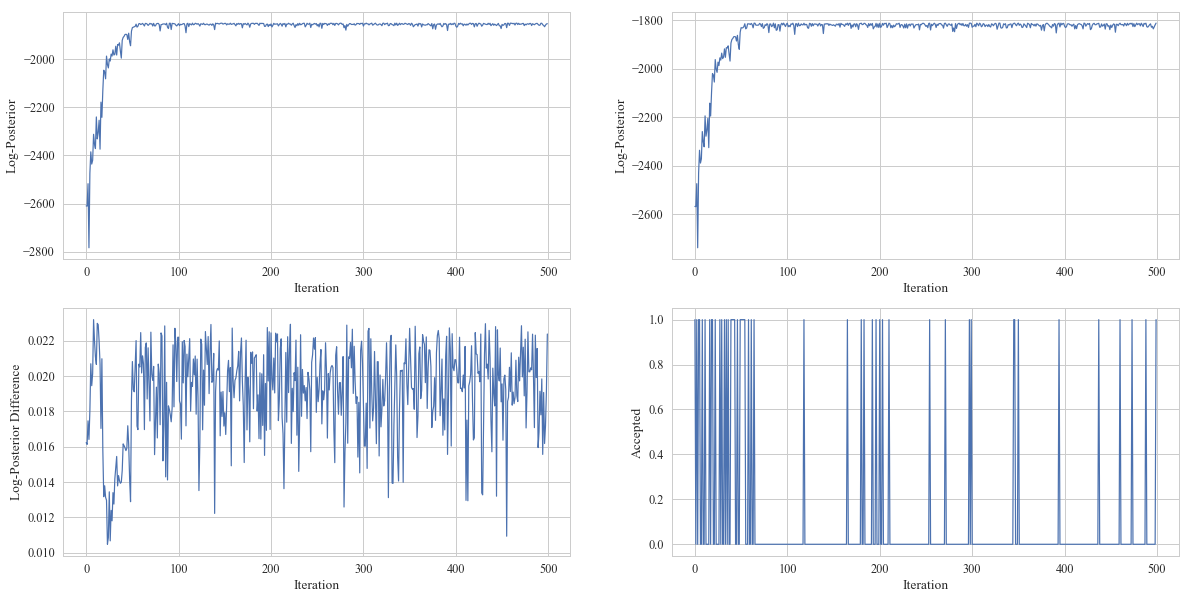

In [56]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                  

ax1.plot(true_chain1[:500])
ax1.set_ylabel('Log-Posterior')
ax1.set_xlabel('Iteration')

ax2.plot(emu_chain1[:500])
ax2.set_ylabel('Log-Posterior')
ax2.set_xlabel('Iteration')

ax3.plot(diffs_chain1[:500])
ax3.set_ylabel('Log-Posterior Difference')
ax3.set_xlabel('Iteration')

ax4.plot(accept_chain1[:500])
ax4.set_ylabel('Accepted')
ax4.set_xlabel('Iteration')

In [57]:
iters = 250

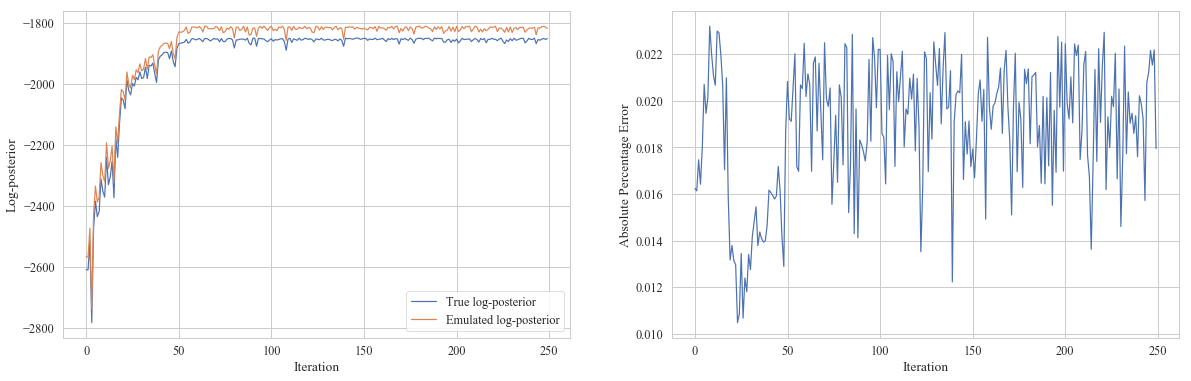

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))    
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log-posterior')
ax1.plot(true_chain1[:iters], label='True log-posterior')
ax1.plot(emu_chain1[:iters], label='Emulated log-posterior')

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Absolute Percentage Error')
ax2.plot(diffs_chain1[:iters])
ax1.legend()
plt.show()
fig.savefig("figures/log-posteriors-chain1.png", bbox_inches='tight', dpi=200)

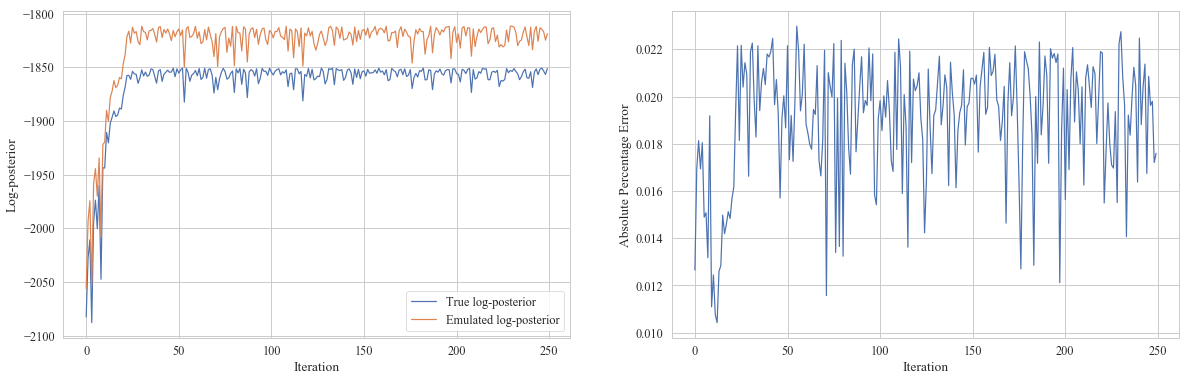

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))    
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log-posterior')
ax1.plot(true_chain2[:iters], label='True log-posterior')
ax1.plot(emu_chain2[:iters], label='Emulated log-posterior')

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Absolute Percentage Error')
ax2.plot(diffs_chain2[:iters])
ax1.legend()
plt.show()
fig.savefig("figures/log-posteriors-chain2.png", bbox_inches='tight', dpi=200)

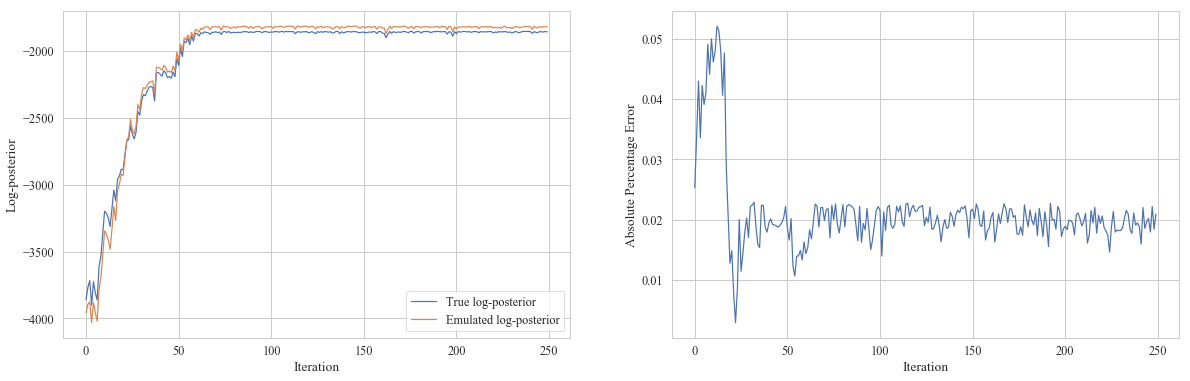

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))    
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log-posterior')
ax1.plot(true_chain3[:iters], label='True log-posterior')
ax1.plot(emu_chain3[:iters], label='Emulated log-posterior')

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Absolute Percentage Error')
ax2.plot(diffs_chain3[:iters])
ax1.legend()
plt.show()
fig.savefig("figures/log-posteriors-chain3.png", bbox_inches='tight', dpi=200)

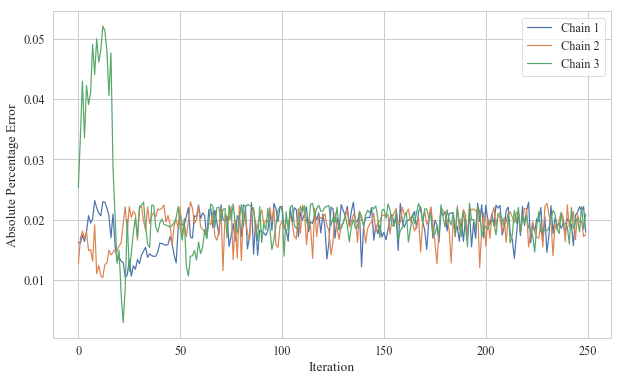

In [61]:
fig, ax = plt.subplots(figsize=(10,6))    

plt.xlabel('Iteration')
plt.ylabel('Absolute Percentage Error')
plt.plot(diffs_chain1[:iters], label='Chain 1')
plt.plot(diffs_chain2[:iters], label='Chain 2')
plt.plot(diffs_chain3[:iters], label='Chain 3')
plt.legend()
plt.show()
fig.savefig("figures/errors-all-chains.png", bbox_inches='tight', dpi=200)